In [61]:
# Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

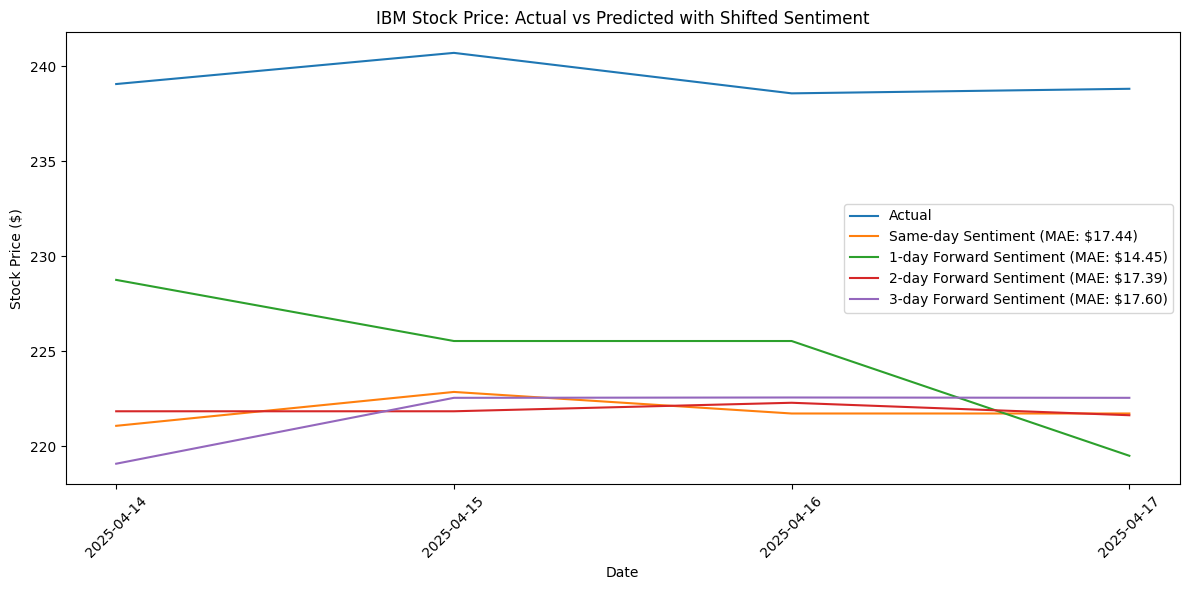

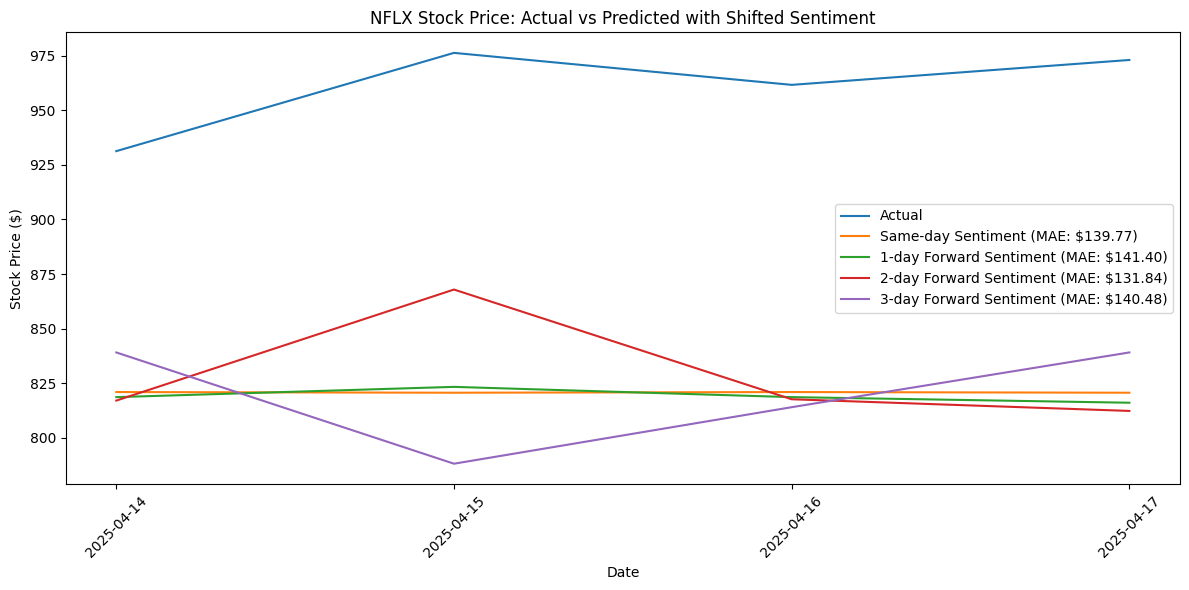

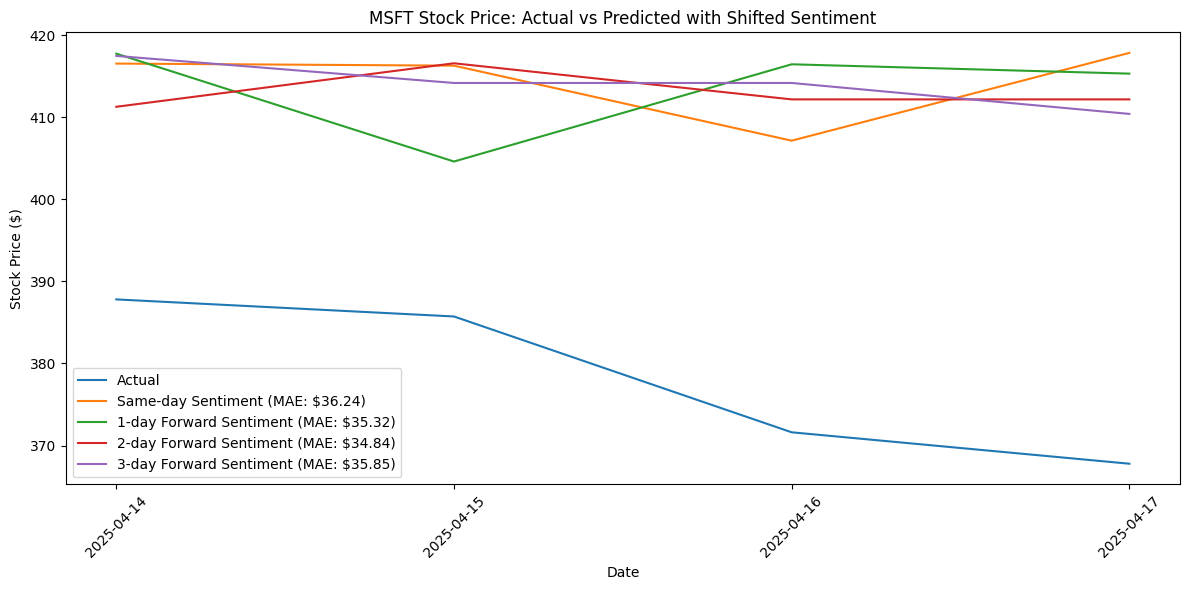

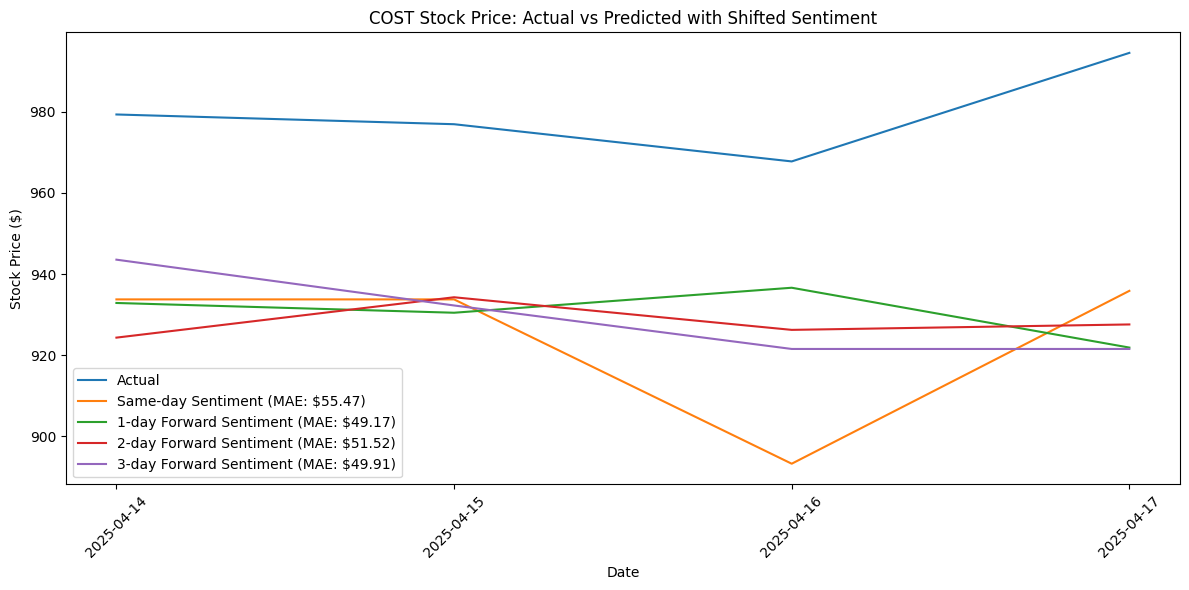

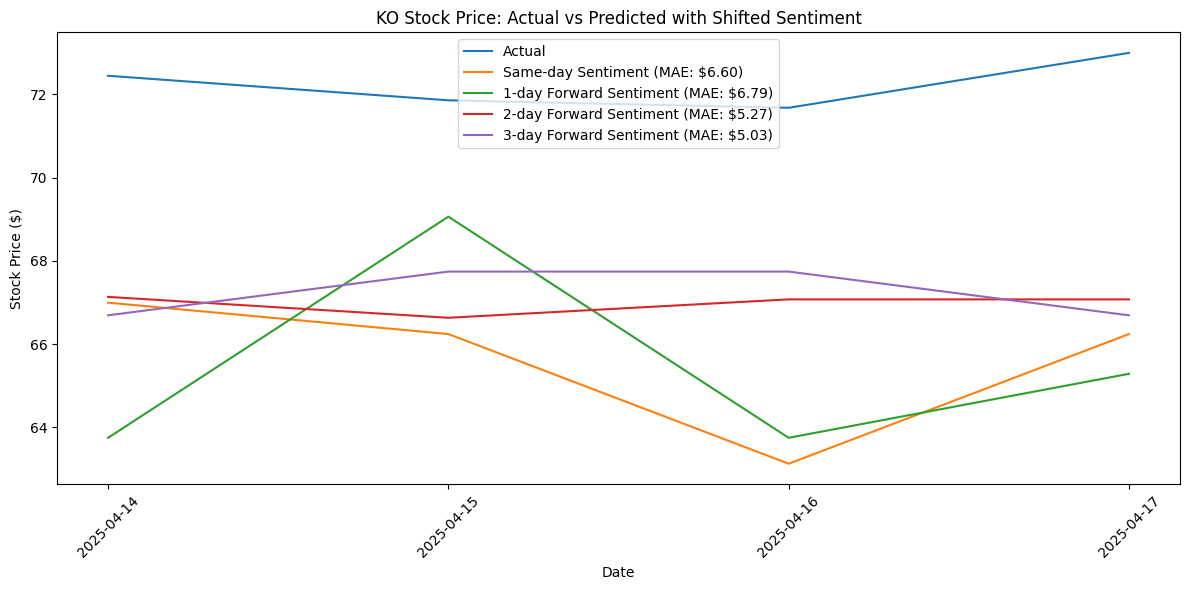

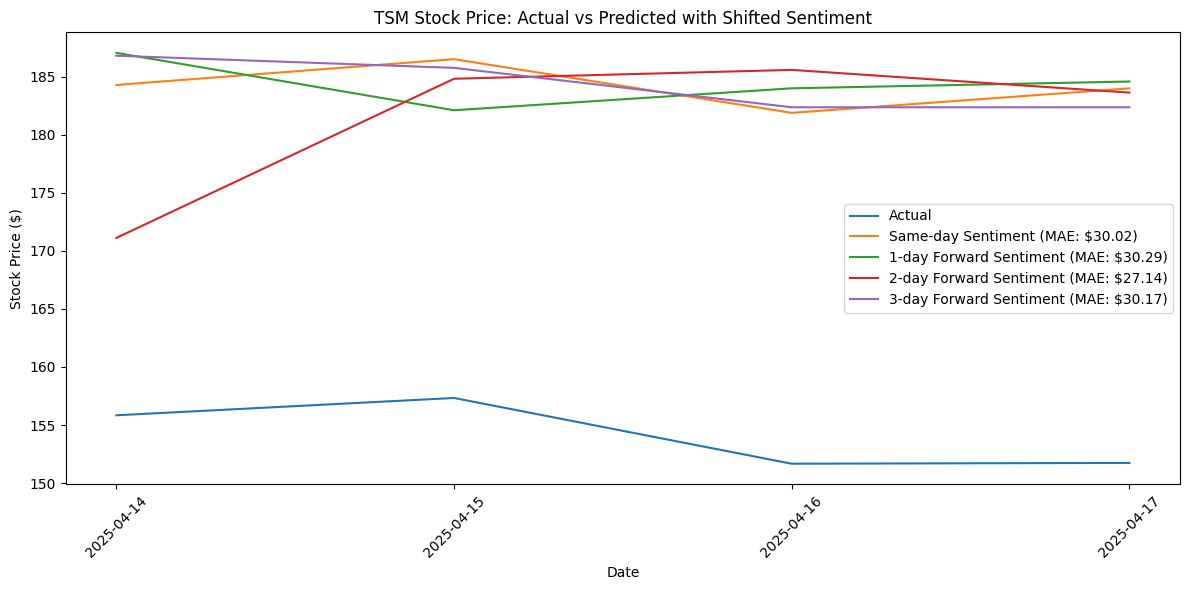

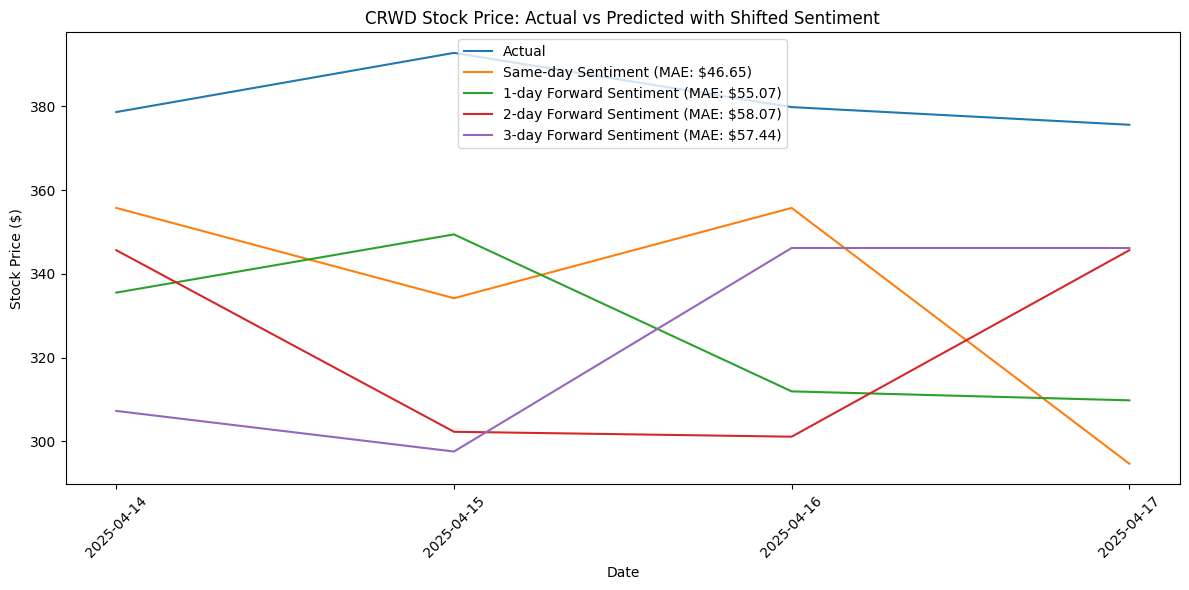

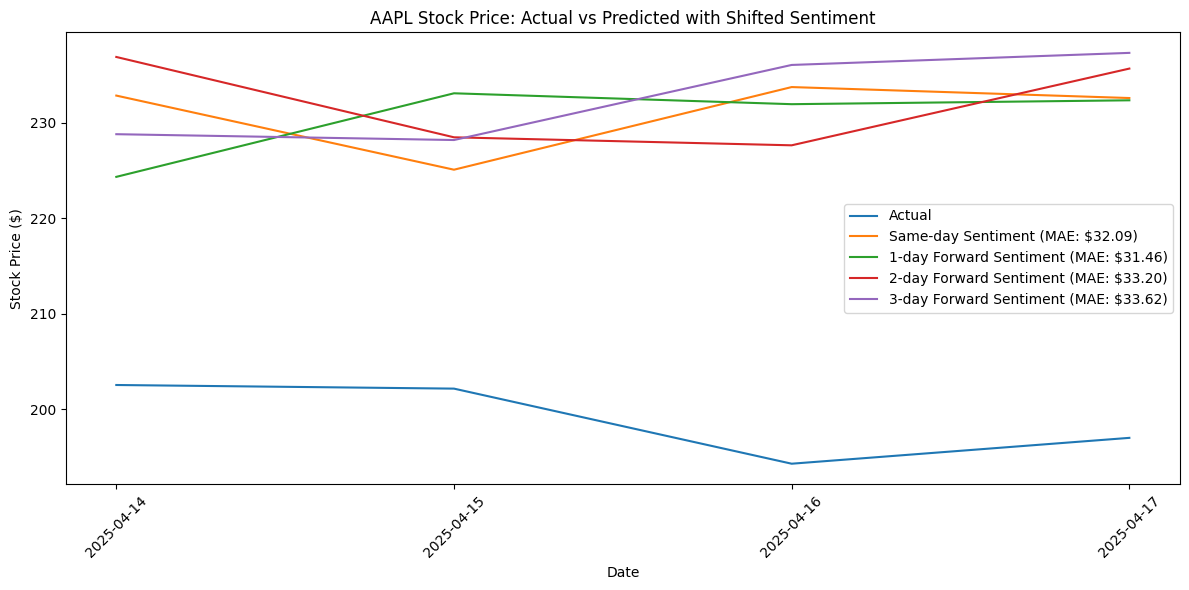

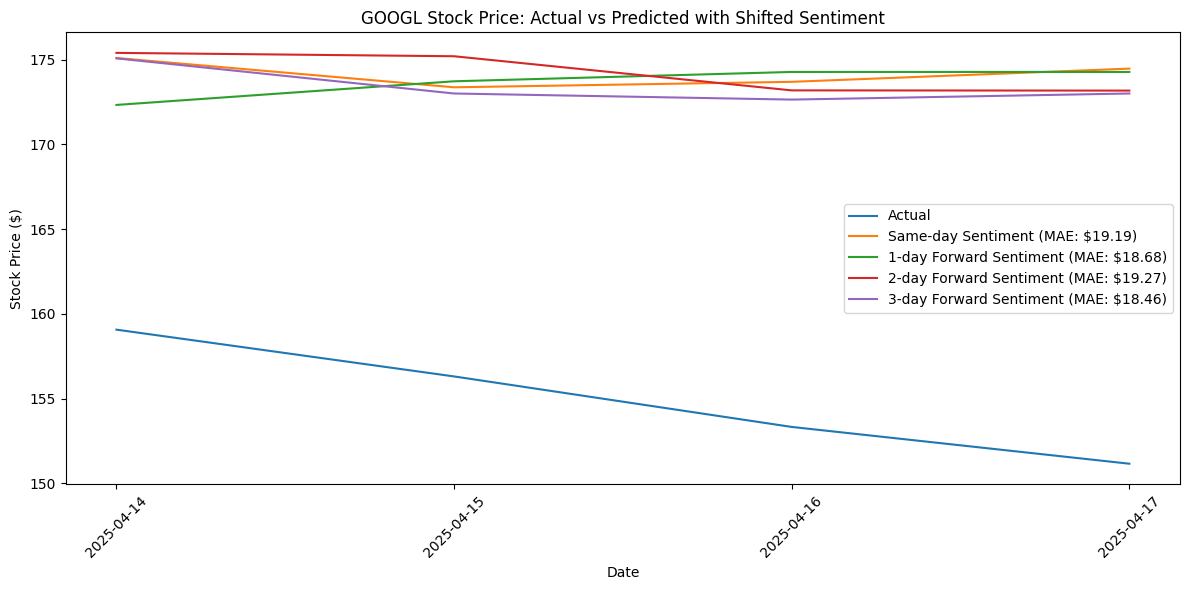

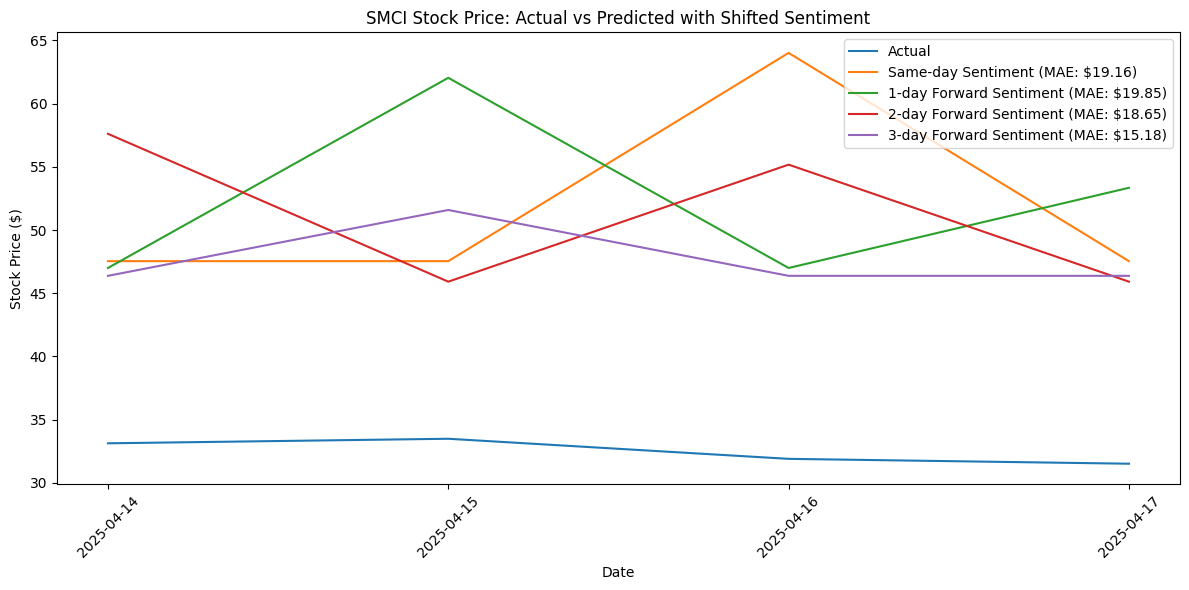

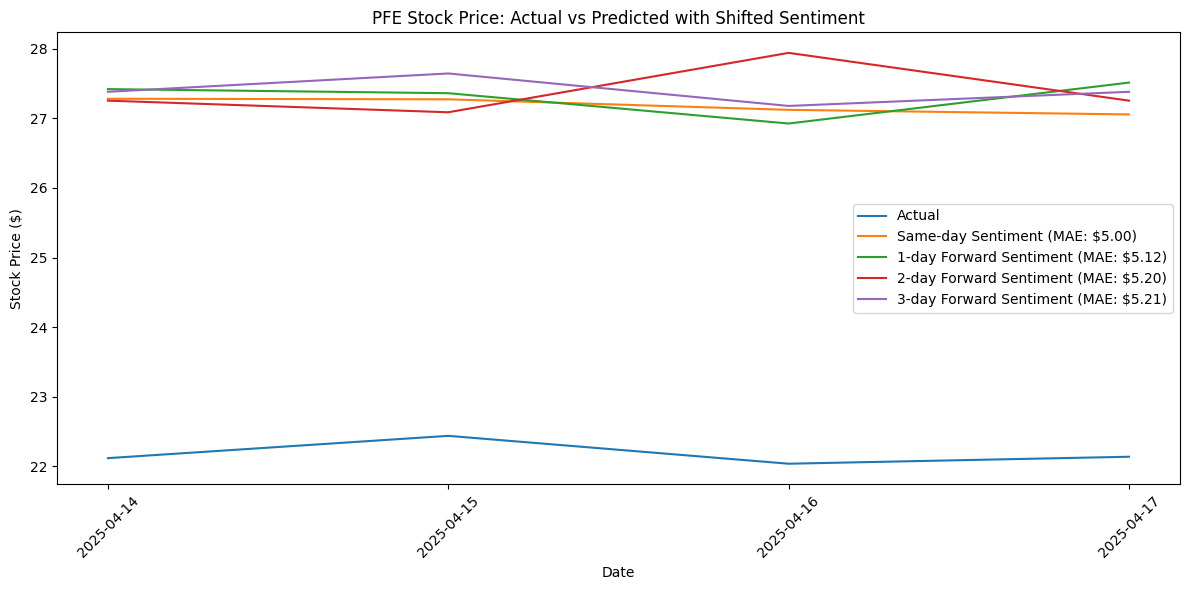

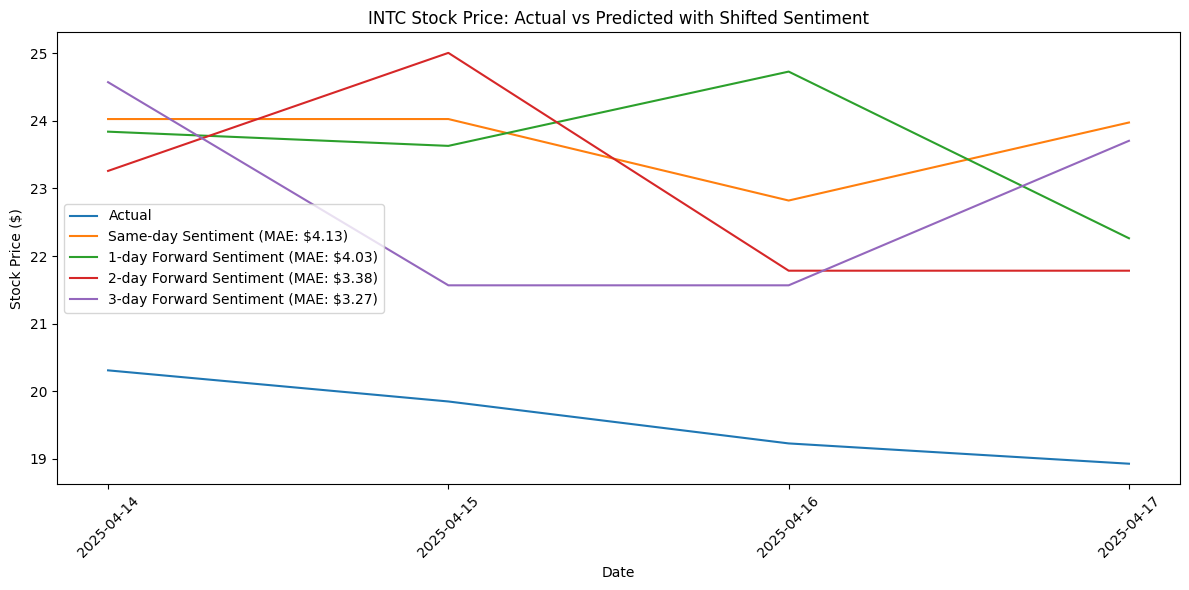

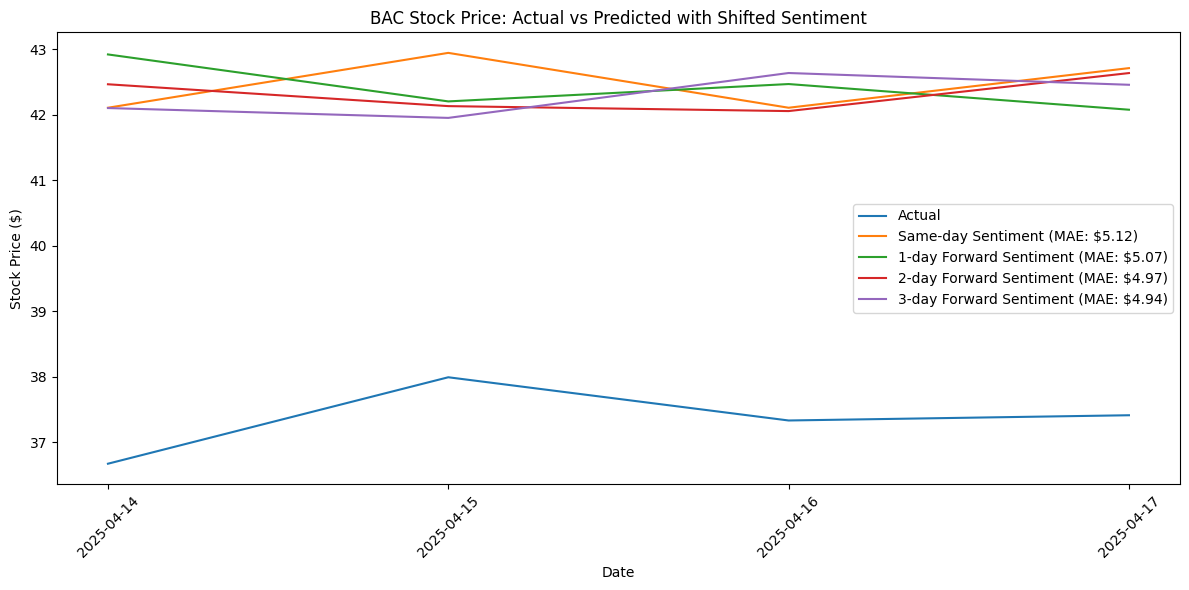

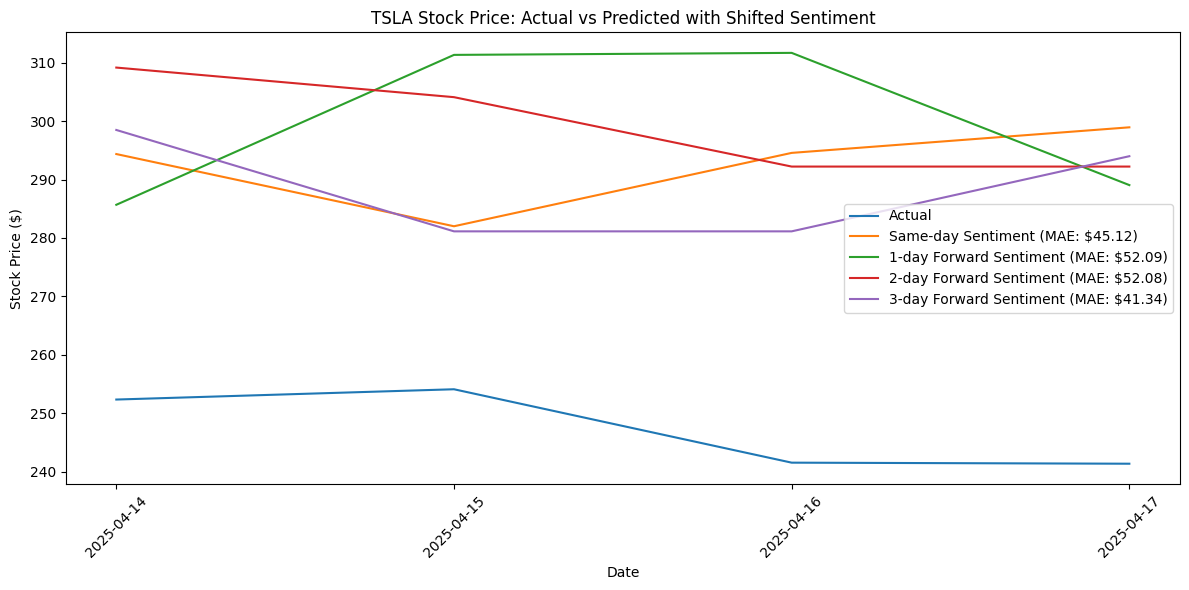

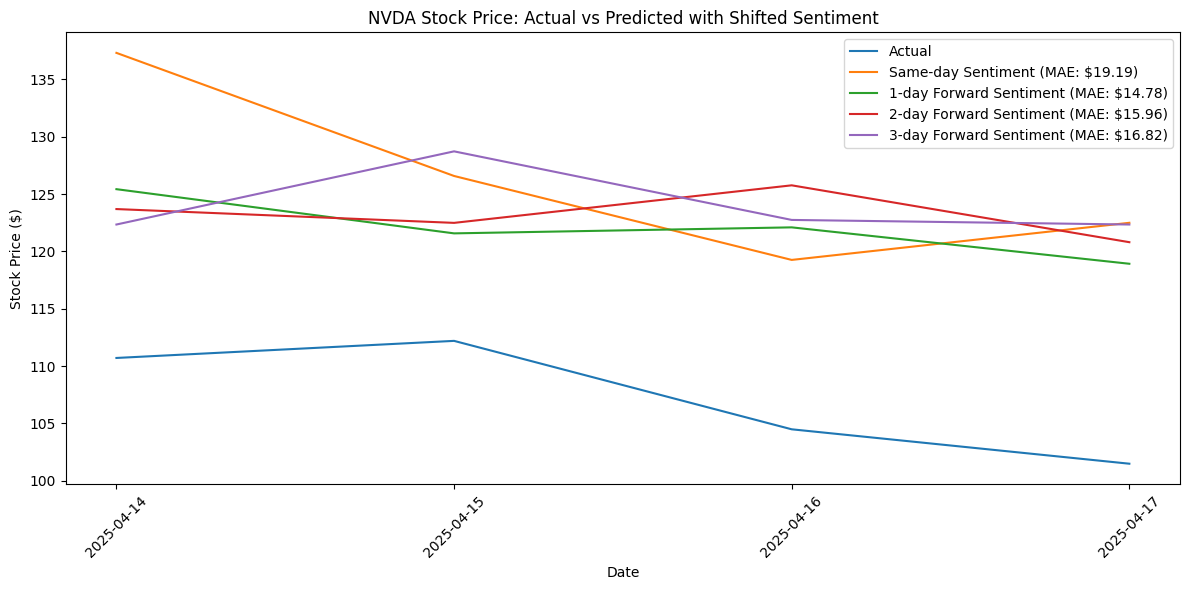

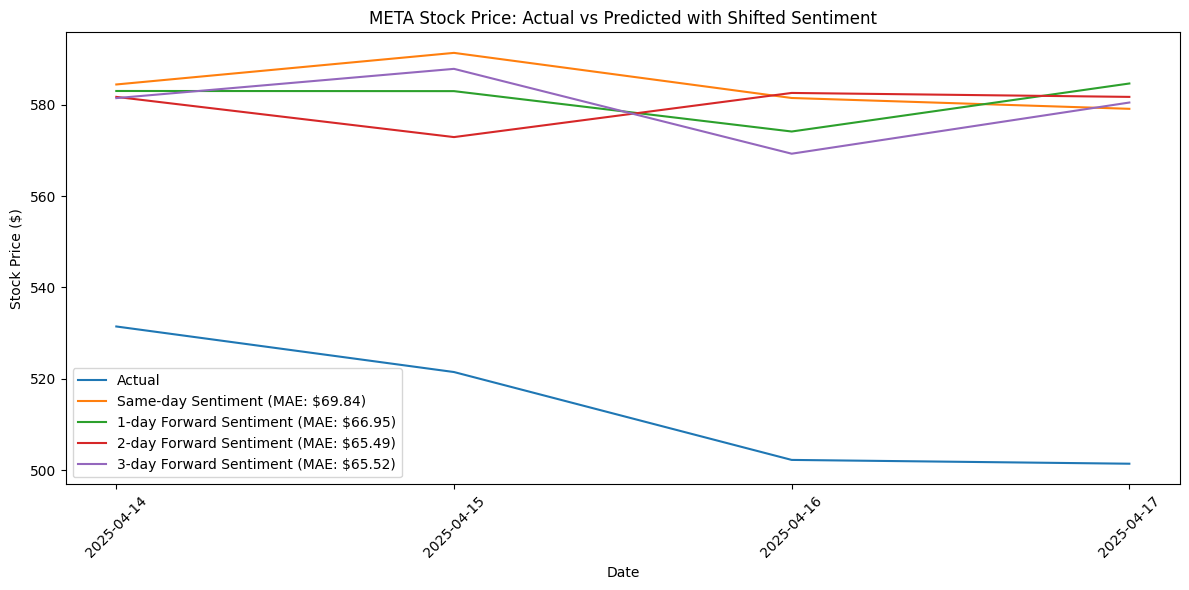

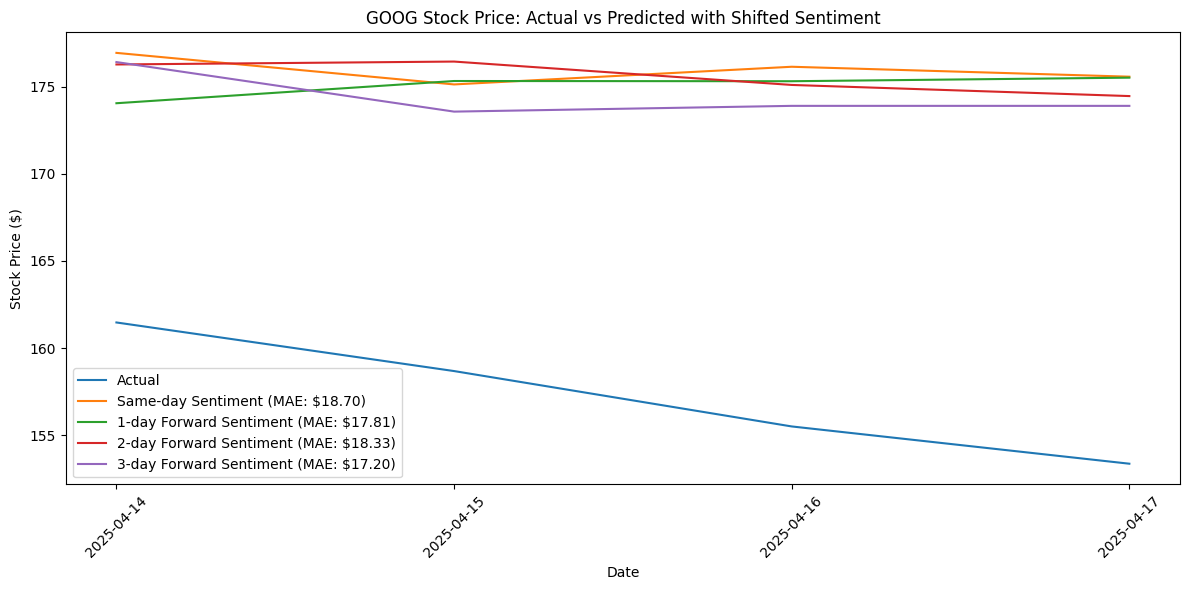

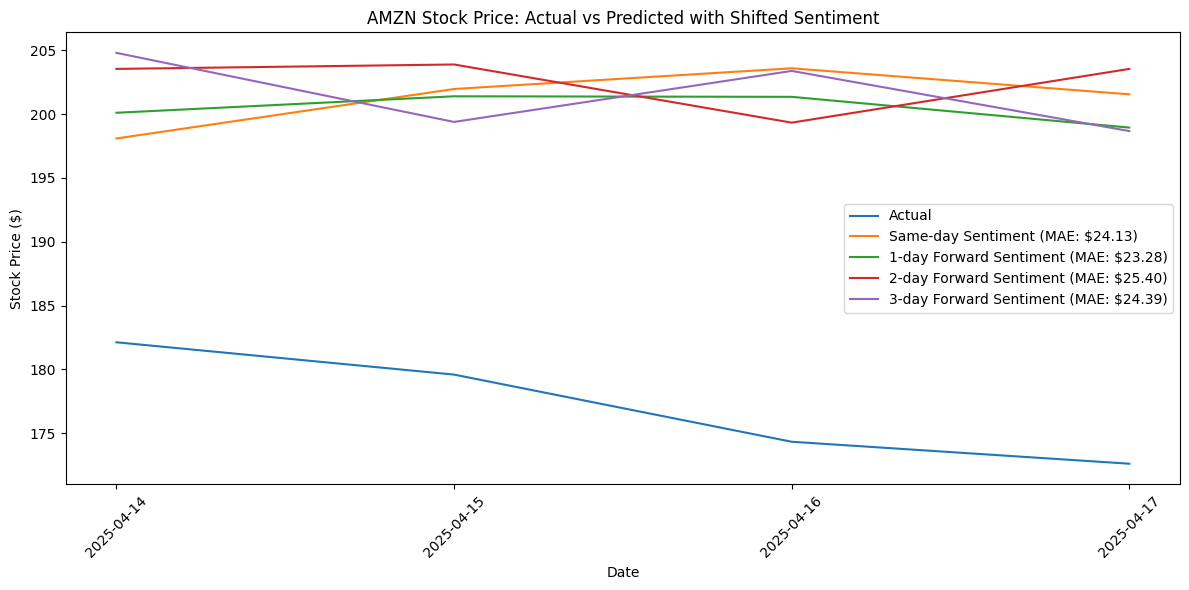

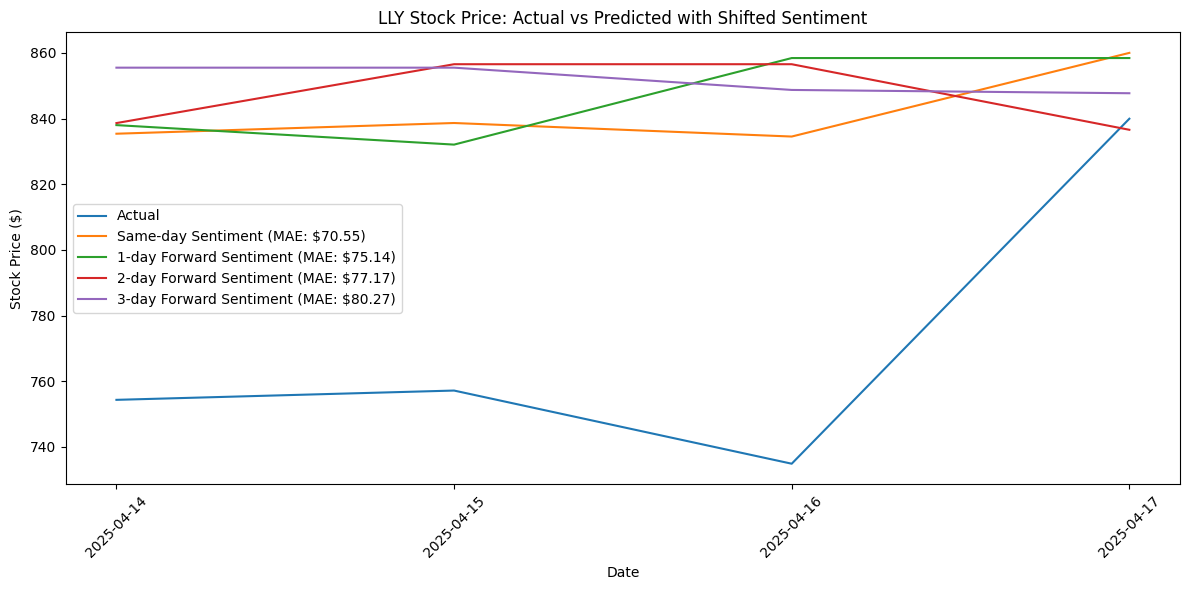

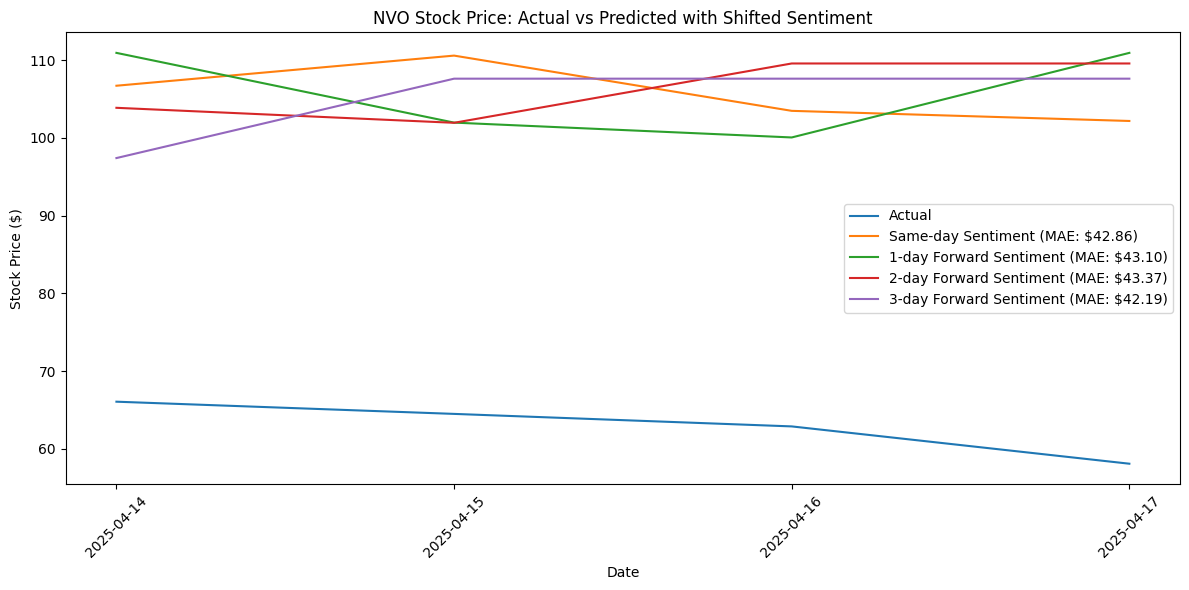

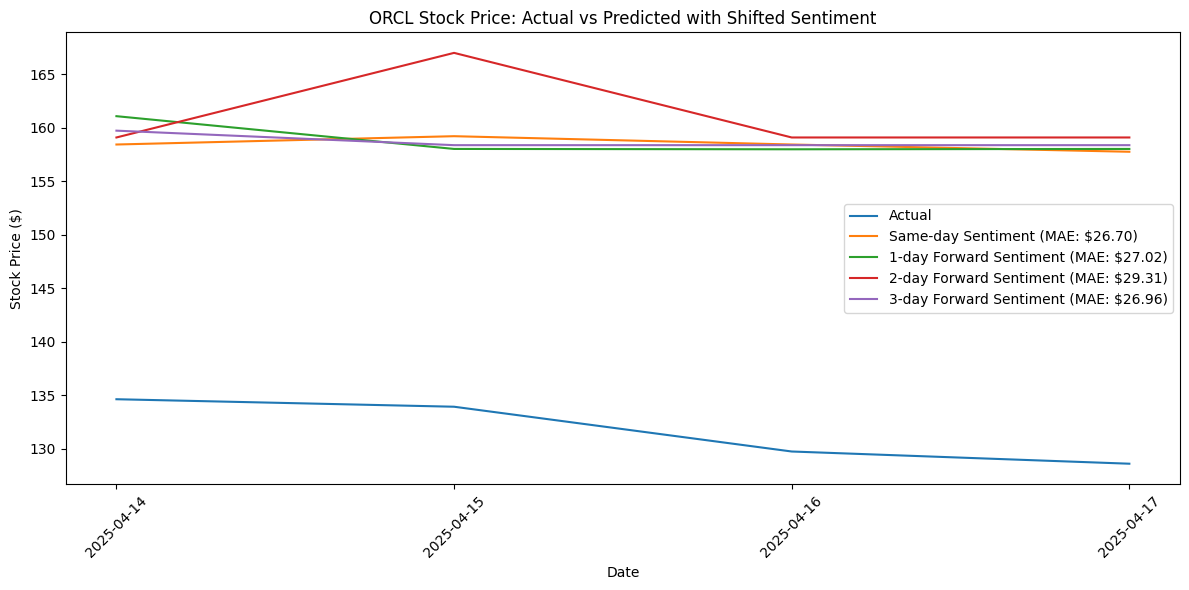

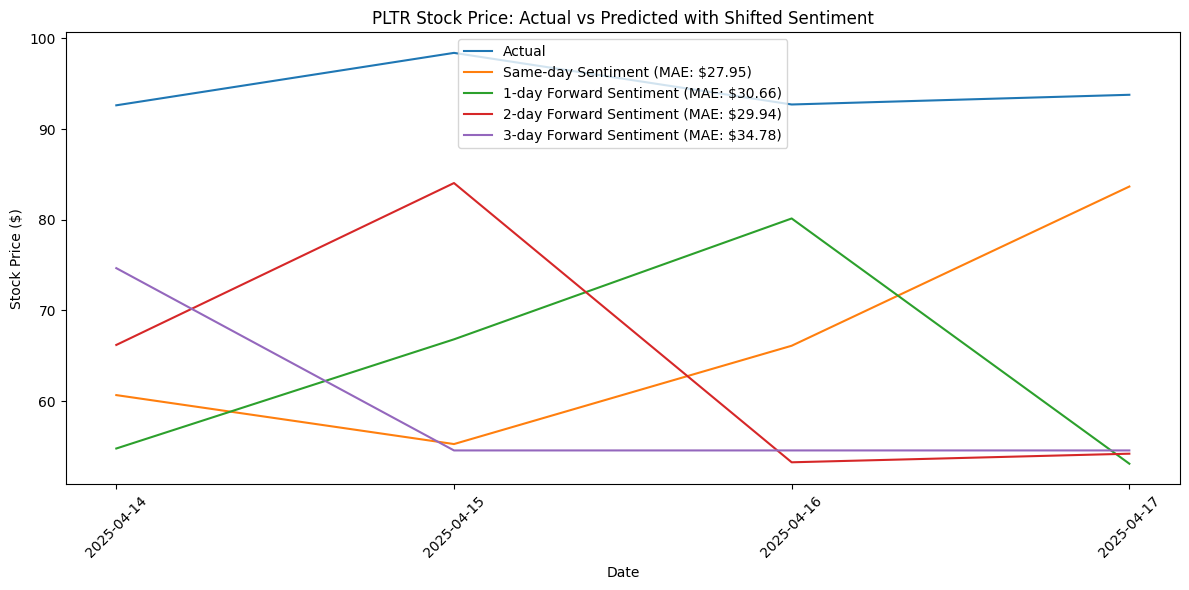

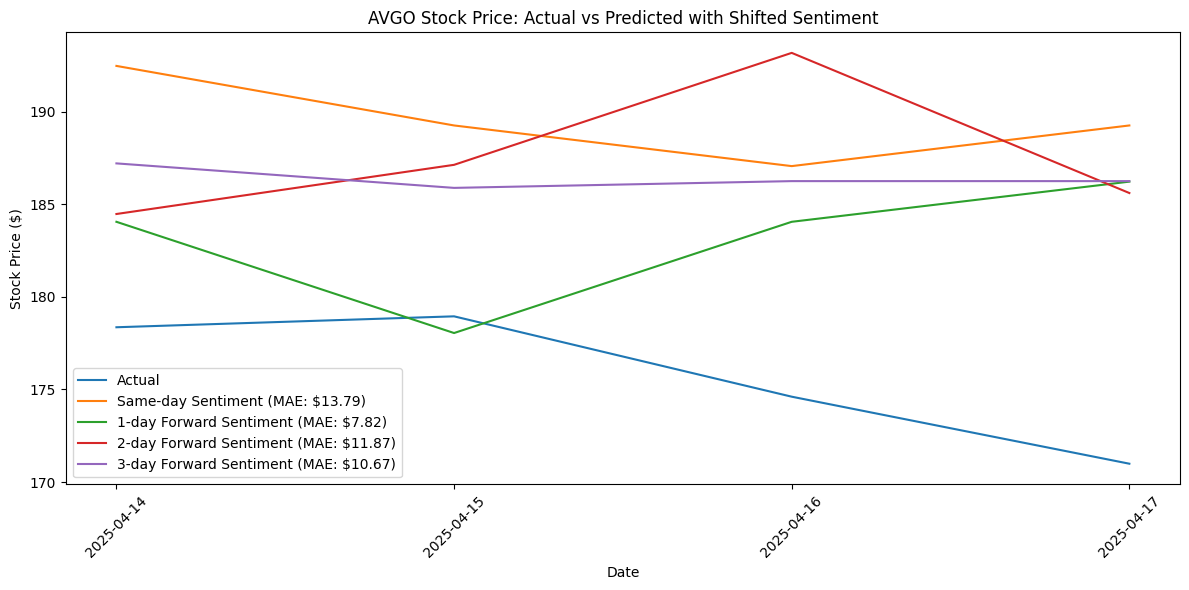

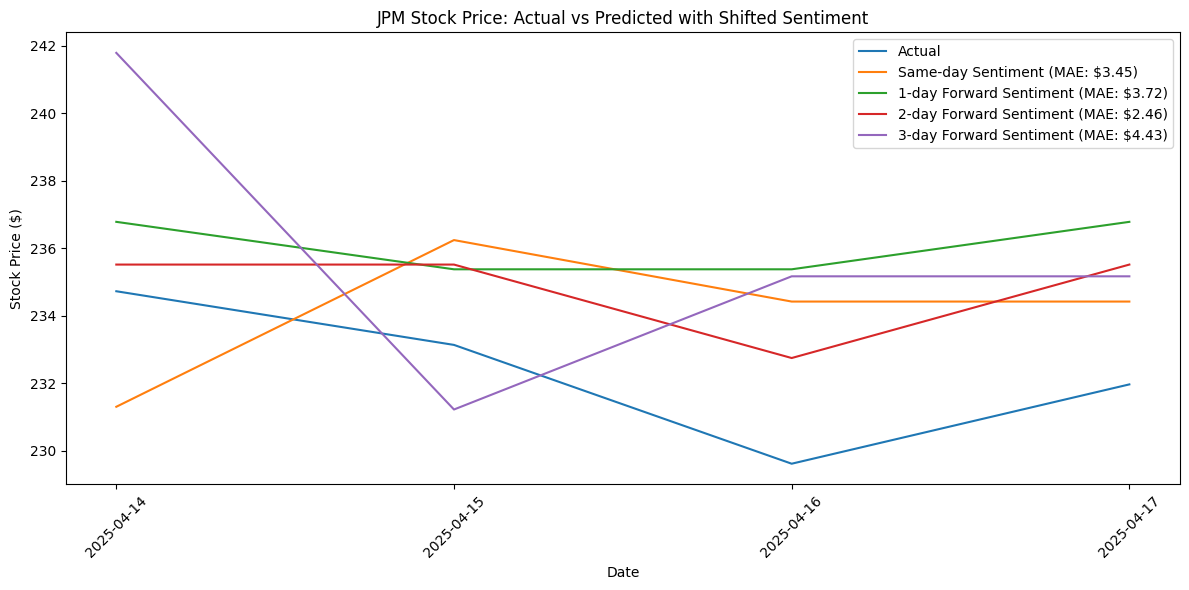

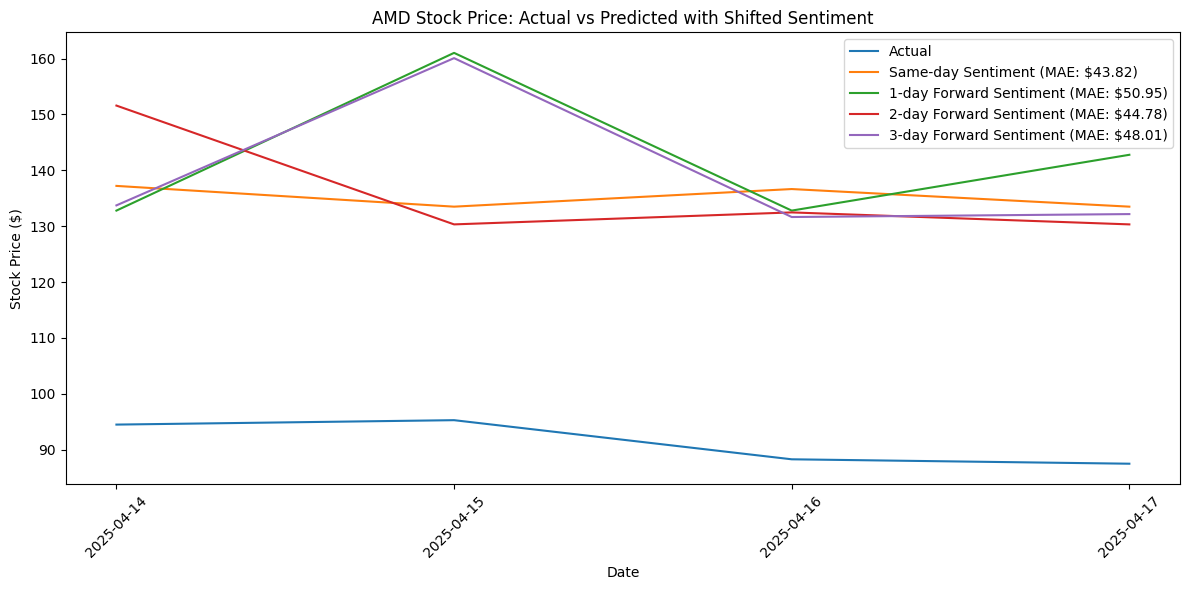

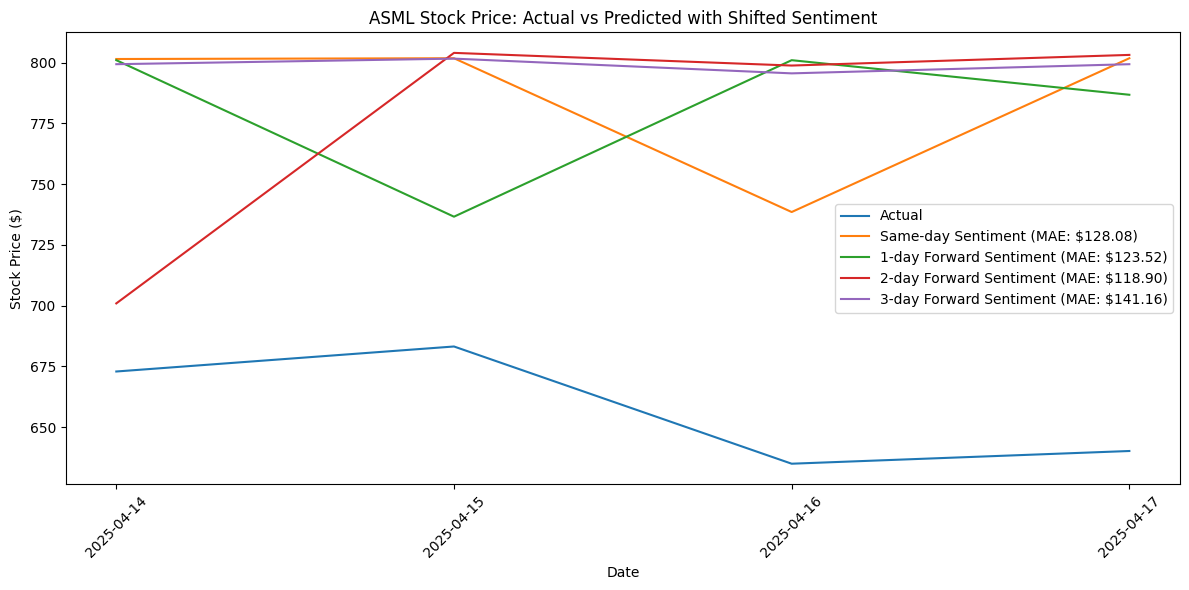

In [64]:
import os
import glob

# Get all stock files
news_files = glob.glob('data_collection/data/news/tsv/*.tsv')
stocks = [os.path.basename(f).replace('.tsv', '') for f in news_files]

# Store results for comparison
results = {}

for stock in stocks:
    # Read data
    news_df = pd.read_csv(f'data_collection/data/news/tsv/{stock}.tsv', sep='\t')
    trades_df = pd.read_csv(f'data_collection/data/trades/tsv/{stock}.tsv', sep='\t')
    
    # Filter out data past 2025-04-25
    trades_df = trades_df[trades_df['date'] <= '2025-04-19']
    news_df = news_df[news_df['published_utc'].str[:10] <= '2025-04-25']

    data = trades_df
    # Add sentiment counts
    sentiment_counts = news_df.groupby(news_df['published_utc'].str[:10])['sentiment'].value_counts().unstack(fill_value=0)
    sentiment_counts = sentiment_counts[['positive', 'neutral', 'negative']]
    sentiment_counts['culmination'] = sentiment_counts['positive'] * 1 + sentiment_counts['negative'] * -10
    
    # Create shifted sentiment counts (1, 2, and 3 days)
    sentiment_counts_1day = sentiment_counts.copy()
    sentiment_counts_1day.index = pd.to_datetime(sentiment_counts_1day.index)
    sentiment_counts_1day = sentiment_counts_1day.shift(-1, freq='D')
    
    sentiment_counts_2day = sentiment_counts.copy()
    sentiment_counts_2day.index = pd.to_datetime(sentiment_counts_2day.index)
    sentiment_counts_2day = sentiment_counts_2day.shift(-2, freq='D')
    
    sentiment_counts_3day = sentiment_counts.copy()
    sentiment_counts_3day.index = pd.to_datetime(sentiment_counts_3day.index)
    sentiment_counts_3day = sentiment_counts_3day.shift(-3, freq='D')

    # Merge regular sentiment counts with data
    data = data.merge(sentiment_counts, left_on=data['date'].str[:10], right_index=True, how='left')
    data[['positive', 'neutral', 'negative', 'culmination']] = data[['positive', 'neutral', 'negative', 'culmination']].fillna(0).astype(int)
    
    # Create features and target for original model
    X = data[['positive', 'neutral', 'negative', 'culmination']]
    y = data['close']

    # Split data
    train_mask = data['date'] < '2025-04-12'
    X_train = X[train_mask]
    X_test = X[~train_mask]
    y_train = y[train_mask]
    y_test = y[~train_mask]

    # Train original model
    model = AdaBoostRegressor(random_state=42, learning_rate=0.1)
    model.fit(X_train, y_train)

    # Make predictions with original model
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    
    # Process data for shifted sentiment models
    data_1day = trades_df.copy()
    data_1day['date_dt'] = pd.to_datetime(data_1day['date'].str[:10])
    data_1day = data_1day.merge(sentiment_counts_1day, left_on='date_dt', right_index=True, how='left')
    data_1day[['positive', 'neutral', 'negative', 'culmination']] = data_1day[['positive', 'neutral', 'negative', 'culmination']].fillna(0).astype(int)
    
    data_2day = trades_df.copy()
    data_2day['date_dt'] = pd.to_datetime(data_2day['date'].str[:10])
    data_2day = data_2day.merge(sentiment_counts_2day, left_on='date_dt', right_index=True, how='left')
    data_2day[['positive', 'neutral', 'negative', 'culmination']] = data_2day[['positive', 'neutral', 'negative', 'culmination']].fillna(0).astype(int)
    
    data_3day = trades_df.copy()
    data_3day['date_dt'] = pd.to_datetime(data_3day['date'].str[:10])
    data_3day = data_3day.merge(sentiment_counts_3day, left_on='date_dt', right_index=True, how='left')
    data_3day[['positive', 'neutral', 'negative', 'culmination']] = data_3day[['positive', 'neutral', 'negative', 'culmination']].fillna(0).astype(int)
    
    # Create features for shifted models
    X_1day = data_1day[['positive', 'neutral', 'negative', 'culmination']]
    X_2day = data_2day[['positive', 'neutral', 'negative', 'culmination']]
    X_3day = data_3day[['positive', 'neutral', 'negative', 'culmination']]
    
    # Split data for shifted models
    X_1day_train = X_1day[train_mask]
    X_1day_test = X_1day[~train_mask]
    X_2day_train = X_2day[train_mask]
    X_2day_test = X_2day[~train_mask]
    X_3day_train = X_3day[train_mask]
    X_3day_test = X_3day[~train_mask]
    
    # Train shifted models
    model_1day = AdaBoostRegressor(random_state=42, learning_rate=0.1)
    model_1day.fit(X_1day_train, y_train)
    
    model_2day = AdaBoostRegressor(random_state=42, learning_rate=0.1)
    model_2day.fit(X_2day_train, y_train)
    
    model_3day = AdaBoostRegressor(random_state=42, learning_rate=0.1)
    model_3day.fit(X_3day_train, y_train)
    
    # Make predictions with shifted models
    predictions_1day = model_1day.predict(X_1day_test)
    predictions_2day = model_2day.predict(X_2day_test)
    predictions_3day = model_3day.predict(X_3day_test)
    
    # Calculate MAEs for shifted models
    mae_1day = mean_absolute_error(y_test, predictions_1day)
    mae_2day = mean_absolute_error(y_test, predictions_2day)
    mae_3day = mean_absolute_error(y_test, predictions_3day)
    
    # Store results
    results[stock] = {
        'mae': mae,
        'mae_1day': mae_1day,
        'mae_2day': mae_2day,
        'mae_3day': mae_3day,
        'actual': y_test,
        'predicted': predictions,
        'predicted_1day': predictions_1day,
        'predicted_2day': predictions_2day,
        'predicted_3day': predictions_3day,
        'dates': data.loc[~train_mask, 'date']
    }

    # Plot predictions
    plt.figure(figsize=(12,6))
    plt.plot(data.loc[~train_mask, 'date'], y_test, label='Actual')
    plt.plot(data.loc[~train_mask, 'date'], predictions, label=f'Same-day Sentiment (MAE: ${mae:.2f})')
    plt.plot(data.loc[~train_mask, 'date'], predictions_1day, label=f'1-day Forward Sentiment (MAE: ${mae_1day:.2f})')
    plt.plot(data.loc[~train_mask, 'date'], predictions_2day, label=f'2-day Forward Sentiment (MAE: ${mae_2day:.2f})')
    plt.plot(data.loc[~train_mask, 'date'], predictions_3day, label=f'3-day Forward Sentiment (MAE: ${mae_3day:.2f})')
    plt.title(f'{stock} Stock Price: Actual vs Predicted with Shifted Sentiment')
    plt.xlabel('Date')
    plt.ylabel('Stock Price ($)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()